### helper routines and constants

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

#Constants
PI_180 = np.pi/180.
_default_Re = 6.378e6

#utility function to plot grids
def plot_mesh_in_latlon(lam, phi, stride=1, phi_color='k', lam_color='r', newfig=True, title=None):
    import matplotlib.pyplot as plt
#    import seaborn as sns; sns.set()
    if (phi.shape != lam.shape): raise Exception('Ooops: lam and phi should have same shape')
    nj,ni = lam.shape
    if(newfig):
        plt.figure(figsize=(10,10))
    for i in range(0,ni,stride):
        plt.plot(lam[:,i],phi[:,i],lam_color)
    for j in range(0,nj,stride):
        plt.plot(lam[j,:],phi[j,:],phi_color)
    if title is not None:
        plt.title(title)
#    plt.show()
        
def plot_mesh_in_xyz(lam, phi, stride=1, phi_color='k', lam_color='r', lowerlat=None, upperlat=None, newfig=True, title=None):
    if lowerlat is not None:
        lam,phi = cut_below(lam,phi,lowerlat=lowerlat)        
    if upperlat is not None:
        lam,phi = cut_above(lam,phi,upperlat=upperlat)        
    x = np.cos(phi*PI_180) * np.cos(lam*PI_180)
    y = np.cos(phi*PI_180) * np.sin(lam*PI_180)
    z = np.sin(phi*PI_180)        
    plot_mesh_in_latlon(x, y, stride=stride, phi_color=phi_color, lam_color=lam_color, newfig=newfig, title=title)

def displacedPoleCap_plot(x_s,y_s,lon0,lon_dp,lat0_SO, stride=40,block=False):
    plt.figure(figsize=(10,10))
    x_s=x_s+lon0
    plot_mesh_in_xyz(x_s,y_s, stride=stride, newfig=False)
    lam__ = x_s[-1,0]
    phi__ = y_s[-1,0]
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.annotate("i=0",xy=(x__,y__), xytext=(x__-0.01,y__+0.01),arrowprops=dict(arrowstyle="->"))

    #plot the location of the displaced pole
    lam__=np.array([lon_dp,lon_dp])+lon0
    phi__=np.array([lat0_SO+2,lat0_SO-2])
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.plot(x__,y__, linestyle='dashed')
    plt.annotate("pole's lon",xy=(x__[0],y__[0]), xytext=(x__[0]-0.01,y__[0]+0.01),arrowprops=dict(arrowstyle="->"))

    n_i=x_s.shape[1]-1
    poles_i=int(n_i*np.mod(lon_dp-lon0,360)/360.)
    lam__=x_s[:,poles_i]
    phi__=y_s[:,poles_i]
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.plot(x__,y__,linewidth=4, color='green')

    antipoles_i=int(n_i*np.mod(180+lon_dp-lon0,360)/360.)
    lam__=x_s[:,antipoles_i]
    phi__=y_s[:,antipoles_i]
    x__ = np.cos(phi__*PI_180) * np.cos(lam__*PI_180)
    y__ = np.cos(phi__*PI_180) * np.sin(lam__*PI_180)
    plt.plot(x__,y__,linewidth=4, color='blue')

def displacedPoleCap_plot2(x_s,y_s,lon0,lon_dp,lat0, stride=40,block=False):
    from mpl_toolkits.basemap import Basemap
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    m = Basemap(projection='spstere',boundinglat=-60,lon_0=300,resolution='l')
    m.drawcoastlines()
    m.fillcontinents(color='coral',lake_color='aqua')
    m.drawparallels(np.arange(lat0,0.,10.),labels=[True,True])
    m.drawmeridians(np.arange(0.,360.,20.),labels=[True,True,True,True])
    m.drawmeridians(np.arange(lon_dp,lon_dp+1,1.),labels=[True,True,True,True],color='r',linewidth=4)
    m.drawmapboundary(fill_color='aqua')

    x, y = m(x_s[::2,::80],y_s[::2,::80])
    plt.plot(x, y, 'ok', markersize=2)
    plt.show(block)

def metrics_error(dx_,dy_,area_,Ni,lat1,lat2=90,Re=_default_Re,bipolar=False,displaced_pole=-999):
    exact_area = 2*np.pi*(Re**2)*np.abs(np.sin(lat2*PI_180)-np.sin(lat1*PI_180))
    exact_lat_arc_length = np.abs(lat2-lat1)*PI_180*Re
    exact_lon_arc_length = np.cos(lat1*PI_180) *2*np.pi*Re
    grid_lat_arc_length = np.sum(dy_[:,Ni//4])
    grid_lon_arc_length = np.sum(dx_[0,:])
    if(lat1>lat2):
        grid_lon_arc_length = np.sum(dx_[-1,:])
    if(bipolar):
        #length of the fold
        grid_lon_arc_length2 = np.sum(dx_[-1,:])
        #This must be 4*grid_lat_arc_length
        lon_arc2_error = 100*(grid_lon_arc_length2/4 - exact_lat_arc_length)/exact_lat_arc_length
    area_error = 100*(np.sum(area_)-exact_area)/exact_area
    lat_arc_error = 100*(grid_lat_arc_length - exact_lat_arc_length)/exact_lat_arc_length    
    lon_arc_error = 100*(grid_lon_arc_length -  exact_lon_arc_length)/exact_lon_arc_length
#    print(exact_lon_arc_length)
#    print(grid_lon_arc_length)    
    if(displaced_pole != -999):
        antipole=displaced_pole+Ni//2
        if(displaced_pole>Ni//2):
            antipole=displaced_pole-Ni//2 
        grid_lat_arc_length = np.sum(dy_[:,displaced_pole]) + np.sum(dy_[:,antipole])
        lat_arc_error = 100*(grid_lat_arc_length - 2.*exact_lat_arc_length)/exact_lat_arc_length
#        print(2.*exact_lat_arc_length)
#        print(grid_lat_arc_length)
    if(bipolar):
        return area_error,lat_arc_error,lon_arc_error,lon_arc2_error
    else:
        return area_error,lat_arc_error,lon_arc_error

def mdist(x1,x2):
    """Returns positive distance modulo 360."""
    a=np.mod(x1-x2+720.,360.)
    b=np.mod(x2-x1+720.,360.)
    d=np.minimum(a,b)
    return d


def generate_grid_metrics_MIDAS(x,y,axis_units='degrees',Re=_default_Re, latlon_areafix=False):
    nytot,nxtot = x.shape
    if  axis_units == 'm':
      metric=1.0
    if  axis_units == 'km':            
      metric=1.e3
    if  axis_units == 'degrees':                        
      metric=Re*PI_180
    ymid_j = 0.5*(y+np.roll(y,shift=-1,axis=0))
    ymid_i = 0.5*(y+np.roll(y,shift=-1,axis=1))      
    dy_j = np.roll(y,shift=-1,axis=0) - y
    dy_i = np.roll(y,shift=-1,axis=1) - y
    dx_i = mdist(np.roll(x,shift=-1,axis=1),x)
    dx_j = mdist(np.roll(x,shift=-1,axis=0),x)
    dx = metric*metric*(dy_i*dy_i + dx_i*dx_i*np.cos(ymid_i*PI_180)*np.cos(ymid_i*PI_180))
    dx = np.sqrt(dx)
    dy = metric*metric*(dy_j*dy_j + dx_j*dx_j*np.cos(ymid_j*PI_180)*np.cos(ymid_j*PI_180))
    dy = np.sqrt(dy)
    dx=dx[:,:-1]
    dy=dy[:-1,:]
    if(latlon_areafix):
        delsin_j = np.roll(np.sin(y*PI_180),shift=-1,axis=0) - np.sin(y*PI_180)
        area=metric*metric*dx_i[:-1,:-1]*delsin_j[:-1,:-1]/PI_180
    else:
        area=dx[:-1,:]*dy[:,:-1]    
    angle_dx=np.zeros((nytot,nxtot))
#    angle_dx = np.arctan2(dy_i,dx_i)/PI_180      
#    self.angle_dx = numpy.arctan2(dy_i,dx_i)*180.0/numpy.pi
    # The commented out code above was incorrect for non-Cartesian grids
    # The corrected version, in addition to including spherical metrics, is centered in the interior and one-sided at the grid edges
    angle_dx[:,1:-1] = np.arctan2(y[:,2:]-y[:,:-2],(x[:,2:]-x[:,:-2])*np.cos(y[:,1:-1]*PI_180))
    angle_dx[:,0]    = np.arctan2(y[:,1] -y[:,0]  ,(x[:,1] -x[:,0]  )*np.cos(y[:,0]*PI_180))
    angle_dx[:,-1]   = np.arctan2(y[:,-1]-y[:,-2] ,(x[:,-1]-x[:,-2] )*np.cos(y[:,-1]*PI_180))
    angle_dx = angle_dx /PI_180
    return dx,dy,area,angle_dx
    

### grid parameters

In [2]:
# Specify the grid properties
# All
# Specify the desired resolution
refineR = 8 #quarter degree grid
refineS=2    # Set to 2 for supergrid
Ni = 360*refineS*refineR

#Southern cap
lon0=-300.  # Starting longitude of the map
lat0_SO=-78.0
Nj_scap=40*refineR
lon_dp=80. # longitude of the displaced pole 
r_dp=0.20
doughnut=0.12
excluded_fraction=doughnut

### Implementation of the algorithm

In [337]:
###
#Displaced pole cap functions
###      
def monotonic_bounding(x,x_0):
    x_im1= x[:,0]*0 + x_0 #Initial value
    for i in range(0,x.shape[1]):
        x[:,i]=np.where(x[:,i]-x_im1[:] > 100, x[:,i]-360, x[:,i])
        x_im1[:] = x[:,i]  
    return x
    
def displacedPoleCap_projection(lon_grid,lat_grid,z_0,r_joint):
    r = np.tan((90+lat_grid) *PI_180)/r_joint
    #Find the theta that has matching resolution at the unit circle with longitude at the joint
    #This is a conformal transformation of the unit circle (inverse to the one below)
    e2itheta = np.cos(lon_grid*PI_180) + 1j*np.sin(lon_grid*PI_180)
    e2ithetaprime = (e2itheta - z_0)/(1. - np.conj(z_0)*e2itheta)
    #Conformal map to displace pole from r=0 to r=r_dispole
    z=r*e2ithetaprime
    w=(z+z_0)/(1+np.conj(z_0)*z)
    #Inverse projection from tangent plane back to sphere
    lamcDP = np.angle(w, deg=True)
    ##lamcDP = np.arctan2(np.imag(w), np.real(w))/PI_180
    ##np.angle returns a value in the interval (-180,180)
    ##However the input grid longitude is in (-lon0,-lon0+360), e.g., (-300,60)
    ##We should shift the angle to be in that interval
    ##But we should also be careful to produce a monotonically increasing longitude, starting from lon0.
    lamcDP = monotonic_bounding(lamcDP,lon_grid[0,0])
    
    rw=np.absolute(w)
    phicDP = -90+np.arctan(rw*r_joint)/PI_180
    return lamcDP,phicDP
    
def displacedPoleCap_baseGrid(i,j,ni,nj,lon0,lat0):
    u = lon0  + i * 360./float(ni)
    a=-90.
    b=lat0 
    v=a + j * (b-a)/float(nj)
    du=np.roll(u,shift=-1,axis=0)-u
    dv=np.roll(v,shift=-1,axis=0)-v
    return u,v,du,dv

def displacedPoleCap_mesh(i,j,ni,nj,lon0,lat0,lam_pole,r_pole,excluded_fraction=None):

    long,latg,du,dv = displacedPoleCap_baseGrid(i,j,ni,nj,lon0,lat0)
    lamg = np.tile(long,(latg.shape[0],1)) 
    phig = np.tile(latg.reshape((latg.shape[0],1)),(1,long.shape[0]))
    #Projection from center of globe to plane tangent at south pole
    r_joint = np.tan((90+lat0)*PI_180) 
    z_0= r_pole * (np.cos(lam_pole*PI_180)+1j*np.sin(lam_pole*PI_180)) 
    lams,phis = displacedPoleCap_projection(lamg,phig,z_0,r_joint)

    if excluded_fraction is not None:
        ny,nx = lamg.shape 
        jmin=np.ceil(excluded_fraction*ny)
        jmin=jmin+np.mod(jmin,2)
        jmint = int(jmin)
        return lams[jmint:,:], phis[jmint:,:]
    else:
        return lams,phis

def generate_displaced_pole_grid(Ni,Nj_scap,lon0,lat0,lon_dp,r_dp):
    print( 'Generating displaced pole grid bounded at latitude ',lat0  )
    print('   rdp=',r_dp)
    i_s=np.arange(Ni+1)
    j_s=np.arange(Nj_scap+1)
    x,y= displacedPoleCap_mesh(i_s,j_s,Ni,Nj_scap,lon0,lat0,lon_dp,r_dp)
    return x,y

In [338]:
#Generate the southern cap grid
#
lon_dp=80.0   # longitude of the displaced pole 
r_dp =0.2
Nj_scap = int(refineR *  40) #To get the same number of points as existing 1/4 degree grids that were generated with MIDAS
Nj_scap = Nj_scap *7//4
doughnut = 0.0 # 0.28 *7/4
lat0_SC=lat0_SO

lamSC,phiSC = generate_displaced_pole_grid(Ni,Nj_scap,lon0,lat0_SC,lon_dp,r_dp)

lat_dp = -90 + np.arctan(r_dp*np.tan((90+lat0_SC)*np.pi/180))*180/np.pi
print("The geographical location of the displaced pole=",lon_dp,lat_dp)

if(doughnut != 0.0):
    jmin=np.ceil(doughnut*Nj_scap)
    jmin=jmin+np.mod(jmin,2)
    jmint = int(jmin)
    lamSC = lamSC[jmint:,:]
    phiSC = phiSC[jmint:,:]

if(phiSC.shape[0]%2 == 0 and ensure_nj_even):
    print("   The number of j's is not even. Fixing this by cutting one row at south.")
    lamSC = np.delete(lamSC,0,0)
    phiSC = np.delete(phiSC,0,0)

print("Starting grid lattitude =", phiSC[0,0])

Generating displaced pole grid bounded at latitude  -78.0
   rdp= 0.2
The geographical location of the displaced pole= 80.0 -87.56574691920382
Starting grid lattitude = -87.56574691920382


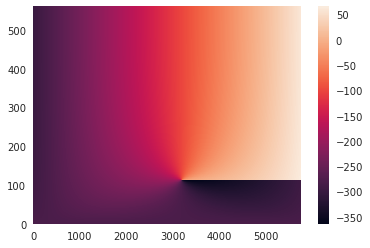

In [339]:
plt.pcolormesh(lamSC); plt.colorbar();


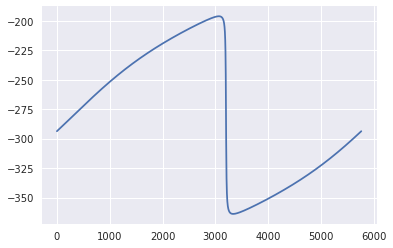

In [340]:
plt.plot(lamSC[113,:]);
#plt.plot([0,6000],[60,60])

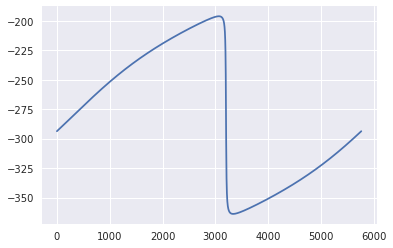

In [341]:
lamc = lamSC*1+0

lamcp=lon0
j=113
for i in range(0,lamc.shape[1]):
    if(lamc[j,i]-lamcp > 100):
        lamc[j,i]=lamc[j,i]-360.
    lamcp = lamc[j,i]   


plt.plot(lamc[j,:]);

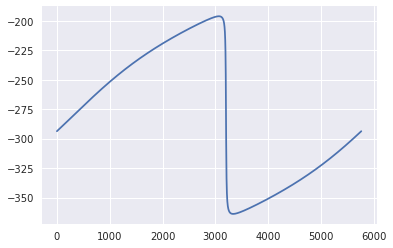

In [342]:
lamc2 = lamSC*1+0

lamcp2= lamc2[:,0]*0 + lon0

for i in range(0,lamc2.shape[1]):
    lamc2[:,i]=np.where(lamc2[:,i]-lamcp2[:] > 100, lamc2[:,i]-360, lamc2[:,i])
    lamcp2[:] = lamc2[:,i]   


plt.plot(lamc[j,:]);

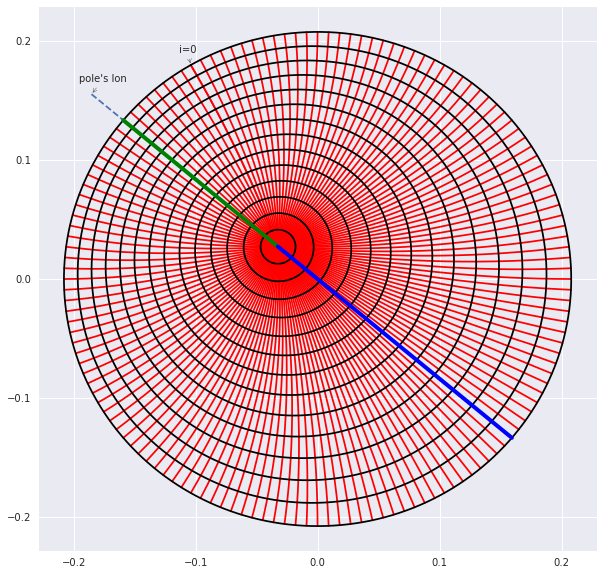

In [343]:
    
displacedPoleCap_plot(lamSC,phiSC,lon0,lon_dp,lat0_SO)
    

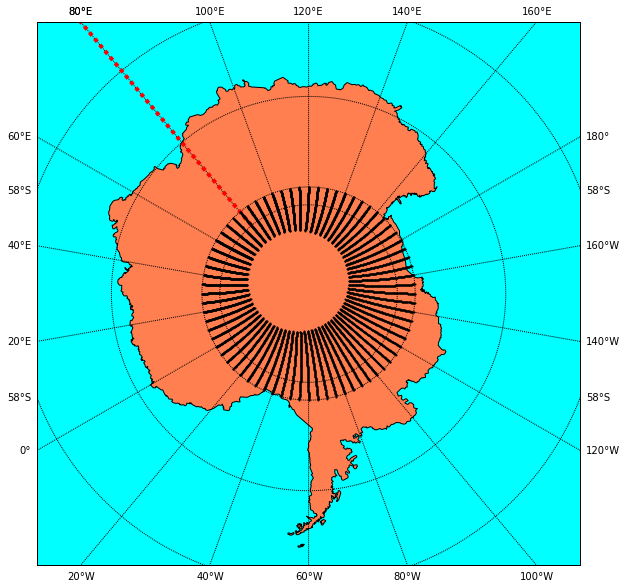

In [8]:
 displacedPoleCap_plot2(lamSC,phiSC,lon0,lon_dp,lat0_SO,block=True)

In [11]:
#generate the metrics
dx_M,dy_M,area_M,angle_M = generate_grid_metrics_MIDAS(lamSC,phiSC,axis_units='degrees',Re=1, latlon_areafix=True)
#write the grid file
#write_nc(lam_,phi_,dx_,dy_,area_,angle_,axis_units='degrees',fnam='south_displaced_cap_new.nc')
print('extent: ',phiSC[-1,0],phiSC[0,0])
poles_i=int(Ni*lon_dp/360.)
print("MIDAS %errors in (area,lat arc,lon arc)", metrics_error(dx_M,  dy_M,  area_M, Ni, lat1=phiSC[-1,0], lat2=-90.,Re=1,displaced_pole=poles_i))


extent:  -78.0 -82.54360839504874
MIDAS %errors in (area,lat arc,lon arc) (-23.701871328316628, -93.38186404460814, -1.1898151289711397e-13)


# Work on the metrics

In [6]:
#General quadrature routines
def quad_positions(n=3):
    """Returns weights wa and wb so that the element [xa,xb] is sampled at positions
    x=wa(xa+xb*xb)."""
    if n==2:
        return np.array([0.,1.]),np.array([1.,0.])
    if n==3:
        return np.array([0.,0.5,1.]),np.array([1.,0.5,0.])
    if n==4:
        r5 = 0.5 / np.sqrt(5.)
        return np.array([0.,0.5-r5,0.5+r5,1.]),np.array([1.,0.5+r5,0.5-r5,0.])
    if n==5:
        r37 = 0.5 * np.sqrt(3./7.)
        return np.array([0.,0.5-r37,0.5,0.5+r37,1.]),np.array([1.,0.5+r37,0.5,0.5-r37,0.])
    raise Exception('Uncoded order')

def quad_average(y):
    """Returns the average value found by quadrature at order n.
    y is a list of values in order from x=-1 to x=1."""
    if len(y)==2: # 1, 1
        d = 1./2.
        return d * ( y[0] + y[1] )
    if len(y)==3: # 1/3, 4/3, 1/3
        d = 1./6.
        return d * ( 4. * y[1] + ( y[0] + y[2] ) )
    if len(y)==4: # 1/6, 5/6, 5/6, 1/6
        d = 1. / 12.
        return d * ( 5. * ( y[1] + y[2] ) + ( y[0] + y[3] ) )
    if len(y)==5: # 9/10, 49/90, 64/90, 49/90, 9/90
        d = 1. / 180.
        return d * ( 64.* y[2] + ( 49. * ( y[1] + y[3] ) )  + 9. * ( y[0] + y[4] ) )
    raise Exception('Uncoded order')
    
def quad_average_2d(y):
    """Returns the average value found by quadrature at order n.
    y is a list of values in order from x1=-1 to x1=1 and x2=-1 to x2=1."""
    if y.shape[0] != y.shape[1]:
        raise Exception('Input array is not squared!')
        
    if y.shape[0]==2: # 1, 1
        d = 1./2.
        return d * d * ( y[0,0] + y[0,1] + y[1,0] + y[1,1] )
    if y.shape[0]==3: # 1/3, 4/3, 1/3
        d = 1./6.
        return d * d * ( y[0,0]+y[0,2]+y[2,0]+y[2,2] +4.*(y[0,1]+y[1,0]+y[1,2]+y[2,1] + 4.*y[1,1])) 
    if y.shape[0]==4: # 1/6, 5/6, 5/6, 1/6
        d = 1. / 12.
#       return d * ( 5. * ( y[1] + y[2] ) + ( y[0] + y[3] ) )
        w = np.array([1.,5.,5.,1.])
        ysum=0.
        for j in range(0,y.shape[0]): 
            for i in range(0,y.shape[1]):
                ysum = ysum+ w[i]*w[j]*y[j,i]
        return d * d * ysum
    if y.shape[0]==5: # 9/10, 49/90, 64/90, 49/90, 9/90
        d = 1. / 180.
        #return d * ( 64.* y[2] + ( 49. * ( y[1] + y[3] ) )  + 9. * ( y[0] + y[4] ) )
        w = np.array([9.,49.,64.,49.,9.])
        ysum=0.
        for j in range(0,y.shape[0]): 
            for i in range(0,y.shape[1]):
                ysum = ysum+ w[i]*w[j]*y[j,i]
        return d * d * ysum
    
    raise Exception('Uncoded order')    

In [7]:
#numerical approximation of metrics coefficients h_i and h_j
def great_arc_distance(j0, i0, j1, i1, nx,ny ,lon0,lat0,lon_dp,r_dp):
    """Returns great arc distance between nodes (j0,i0) and (j1,i1)"""
    # https://en.wikipedia.org/wiki/Great-circle_distance
    lam0,phi0= displacedPoleCap_mesh(i0,j0, nx,ny,lon0,lat0,lon_dp,r_dp)
    lam1,phi1= displacedPoleCap_mesh(i1,j1, nx,ny,lon0,lat0,lon_dp,r_dp)
    lam0,phi0=lam0*PI_180,phi0*PI_180
    lam1,phi1=lam1*PI_180,phi1*PI_180
    dphi, dlam = phi1 - phi0, lam1 - lam0
    # Haversine formula
    d = np.sin( 0.5 * dphi)**2 + np.sin( 0.5 * dlam)**2 * np.cos(phi0) * np.cos(phi1)
    return 2. * np.arcsin( np.sqrt( d ) )

def numerical_hi(j, i, nx,ny ,lon0,lat0,lon_dp,r_dp, eps, order=6):
    """Returns a numerical approximation to h_lambda"""
    reps = 1. / eps 
    ds2 = great_arc_distance(j, i+eps, j, i-eps, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 2: return 0.5 * ds2 * reps
    ds4 = great_arc_distance(j, i+2.*eps, j, i-2.*eps, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 4: return ( 8. * ds2 - ds4 ) * (1./12.) * reps
    ds6 = great_arc_distance(j, i+3.*eps, j, i-3.*eps, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 6: return ( 45. * ds2 - 9. * ds4 + ds6 ) * (1./60.) * reps
    raise Exception('order not coded')

def numerical_hj(j, i, nx,ny ,lon0,lat0,lon_dp,r_dp, eps, order=6):
    """Returns a numerical approximation to h_phi"""
    reps = 1. / eps 
    ds2 = great_arc_distance(j+eps, i, j-eps, i, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 2: return 0.5 * ds2 * reps
    ds4 = great_arc_distance(j+2.*eps, i, j-2.*eps, i, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 4: return ( 8. * ds2 - ds4 ) * (1./12.) * reps
    ds6 = great_arc_distance(j+3.*eps, i, j-3.*eps, i, nx,ny ,lon0,lat0,lon_dp,r_dp)
    if order == 6: return ( 45. * ds2 - 9. * ds4 + ds6 ) * (1./60.) * reps
    raise Exception('order not coded')

quad=4 %errors in (area,lat arc,lon arc) (0.00016259544789205387, -3.0142911854900112e-09, 2.3280687694603659e-08)


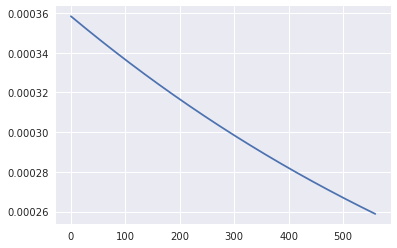

In [8]:
def displacedPoleCap_metrics_quad(order,nx,ny,lat0,lon0,lon_dp,r_dp,Re=_default_Re):
    a,b = quad_positions(order)

    #Note that we need to include the index of the last point of the grid to do the quadrature correctly.
    daq = np.zeros([ny+1,nx+1])
    dxq = np.zeros([ny+1,nx+1])
    dyq = np.zeros([ny+1,nx+1])

    j1d = np.empty([0])
    for j in range(0,ny+1):  
        j_s = b*j + a*(j+1)
        j1d = np.append(j1d,j_s)

    i1d = np.empty([0])
    for i in range(0,nx+1):  
        i_s = b*i + a*(i+1)
        i1d = np.append(i1d,i_s)
    #numerical approximation to h_i_in and h_j_inv at quadrature points
    dx = numerical_hi(j1d, i1d, nx,ny, lon0,lat0,lon_dp,r_dp, eps=1e-3, order=order)
    dy = numerical_hj(j1d, i1d, nx,ny, lon0,lat0,lon_dp,r_dp, eps=1e-3, order=order)
    #reshape to send for quad averaging
    dx_r = dx.reshape(ny+1,order,nx+1,order)
    dy_r = dy.reshape(ny+1,order,nx+1,order)
    
    #area element
    dxdy_r = dx_r*dy_r

    for j in range(0,ny+1):  
        for i in range(0,nx+1):
            daq[j,i] = quad_average_2d(dxdy_r[j,:,i,:])
            dxq[j,i] = quad_average(dx_r[j,0,i,:])
            dyq[j,i] = quad_average(dy_r[j,:,i,0])

    daq = daq[:-1,:-1]*Re*Re   
    dxq = dxq[:,:-1]  *Re
    dyq = dyq[:-1,:]  *Re
    
    return dxq,dyq,daq    

dx_q,dy_q,da_q = displacedPoleCap_metrics_quad(4,Ni,Nj_scap,lat0_SO,lon0,lon_dp,r_dp,Re=1) 
plt.plot(dy_q[:,0])
poles_i=int(Ni*np.mod(lon_dp-lon0,360)/360.)
print("quad=4 %errors in (area,lat arc,lon arc)", metrics_error(dx_q, dy_q, da_q,   Ni, lat1=y_s[-1,0], lat2=-90.,Re=1,displaced_pole=poles_i))
#print("MIDAS %errors in (area,lat arc,lon arc)", metrics_error(dx_M,  dy_M,  area_M, Ni, lat1=y_s[-1,0], lat2=-90.,Re=1,displaced_pole=True))
#MIDAS %errors in (area,lat arc,lon arc) (-6.8380850941997915, 1.7112184507563846, -5.0992076955905986e-14) 

0.137302673996 
 0.137302673996 

0.00404939645597 
 0.00404939569031 



/net2/nnz/opt/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in double_scalars


quad=4 %errors in (area,lat arc,lon arc) (0.00016259544789205387, -3.0142911854900112e-09, 2.3280687694603659e-08)


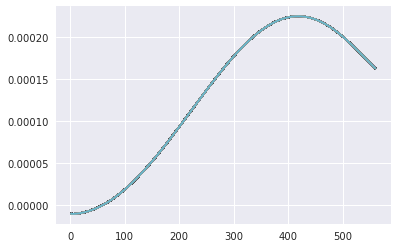

In [31]:
def metrics_error2(dx_,dy_,area_,Ni,lat1,lat2=90,Re=_default_Re,bipolar=False,displaced_pole=-999):
    exact_area = 2*np.pi*(Re**2)*np.abs(np.sin(lat2*PI_180)-np.sin(lat1*PI_180))
    exact_lat_arc_length = np.abs(lat2-lat1)*PI_180*Re
    exact_lon_arc_length = np.cos(lat1*PI_180) *2*np.pi*Re
    grid_lat_arc_length = np.sum(dy_[:,Ni//4])
    grid_lon_arc_length = np.sum(dx_[0,:])
    if(lat1>lat2):
        grid_lon_arc_length = np.sum(dx_[-1,:])
    if(bipolar):
        #length of the fold
        grid_lon_arc_length2 = np.sum(dx_[-1,:])
        #This must be 4*grid_lat_arc_length
        lon_arc2_error = 100*(grid_lon_arc_length2/4 - exact_lat_arc_length)/exact_lat_arc_length
    area_error = 100*(np.sum(area_)-exact_area)/exact_area
    lat_arc_error = 100*(grid_lat_arc_length - exact_lat_arc_length)/exact_lat_arc_length    
    lon_arc_error = 100*(grid_lon_arc_length -  exact_lon_arc_length)/exact_lon_arc_length
#    print(exact_lon_arc_length)
#    print(grid_lon_arc_length)    
    if(displaced_pole != -999):
        antipole=displaced_pole+Ni//2
        if(displaced_pole>Ni//2):
            antipole=displaced_pole-Ni//2 
        grid_lat_arc_length = np.sum(dy_[:,displaced_pole]) + np.sum(dy_[:,antipole])
        lat_arc_error = 100*(grid_lat_arc_length - 2.*exact_lat_arc_length)/exact_lat_arc_length
#        print(2.*exact_lat_arc_length)
#        print(grid_lat_arc_length)
        
        cap_area = lambda perimeter: 2*np.pi*(Re**2)*np.abs(1.-np.sqrt(1-(perimeter/2./np.pi/Re)**2))
        print(exact_area,"\n",cap_area(exact_lon_arc_length),"\n")
        print(np.sum(area_[:100,:]),"\n",cap_area(np.sum(dx_[100,:])),"\n")
        error=np.ones(dx_.shape)
        for j in range(0,dx_.shape[0]):
            area_cap = cap_area(np.sum(dx_[j,:]))
            error[j] = 100*(np.sum(area_[:j,:])-area_cap)/area_cap
        plt.plot(error)                                       
    if(bipolar):
        return area_error,lat_arc_error,lon_arc_error,lon_arc2_error
    else:
        return area_error,lat_arc_error,lon_arc_error

print("quad=4 %errors in (area,lat arc,lon arc)", metrics_error2(dx_q, dy_q, da_q,   Ni, lat1=y_s[-1,0], lat2=-90.,Re=1,displaced_pole=poles_i))
    